In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
import simpleaudio as sa
from scipy import signal
import wavio

### Import Saved Streamflow data
these are **daily average streamflow data** for each gage in the Des Moines River Basin from **October 2010 to September of 2020**

In [2]:
with open('misc/dmrb.pickle', 'rb') as handle:
    dmrb = pickle.load(handle)
df = pd.DataFrame(dmrb,dtype=np.float64)
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df.astype(float,inplace=True)
colsDrop = ['05476500','05476590','05476735','05478265','05480080','05480820','05480930','05489490','05481510','05482315','05482430','05483318','05483349','05483470','05484600']
df.drop(columns = colsDrop ,inplace=True)

df.head()

,05476750,05479000,05480500,05481000,05481300,05481650,05481950,05482000,05482300,05482500,...,05487470,05487520,05487980,05488110,05488200,05488500,05489000,05489500,05490500,05494300
2010-10-01,6560.0,1500,8710,402.0,9110,9230.0,624.0,10100,771.0,2180.0,...,107,15900,114.0,22000,28.3,23300,206.0,23300,24200.0,22.0
2010-10-02,7080.0,1500,9240,367.0,9590,9420.0,560.0,10200,699.0,1970.0,...,93.4,14900,93.7,20800,23.7,22100,175.0,22500,22800.0,18.3
2010-10-03,7420.0,1480,9560,335.0,9940,9790.0,509.0,10500,635.0,1810.0,...,85.3,14500,79.0,19700,23.0,20300,150.0,20900,21600.0,15.8
2010-10-04,7460.0,1440,9660,316.0,10100,10200.0,472.0,10800,593.0,1690.0,...,80.0,14500,71.4,17900,20.0,18400,142.0,19600,20300.0,14.6
2010-10-05,7440.0,1400,9610,303.0,10000,10200.0,442.0,10900,562.0,1600.0,...,76.6,14400,64.5,15900,18.0,16100,130.0,17300,18700.0,13.8


### Define Functions to use
No need to read this part...

In [3]:
def wave(t,f,a,wtype):
    func = {'sin':np.sin, 'saw':signal.sawtooth, 'square':signal.square}
    if wtype == 'sin':
        return a * func[wtype](f * t * 2 * np.pi) * a/2 * func[wtype](2 * f * t * np.pi)
    else:
        return a * func[wtype](2 * np.pi * f * t)

def waveform(t,d,extras=[]):
    # Form
    # [method,a,f]
    
    func = {'sin':np.sin, 'saw':signal.sawtooth, 'square':signal.square}
    
    # create base wave form with dominant freq and harmonic(s)
    wave = d[1] * func[d[0]](d[2] * t * 2 * np.pi) + d[1]/2 * func[d[0]](2 * d[2] * t * 2 * np.pi) 
    
    # and movement given other gages (upstream)
    # [method,a,f]
    for w in extras:
        wave += w[1] * func[w[0]](2 * np.pi * w[2] * t)
    
    return wave

def linkTones(tones):
    for t in tones:
        l = int(len(t)/4)
        for i in range(0,l):
            t[len(t) - l+i] *= (1 - i /l)
            t[i] *= i/l
            
    full = np.concatenate(tones)
    full = full * (2**15 - 1) / np.max(np.abs(full))
    return full.astype(np.int16)

def linearFlow2Freq(flow,flowLimits,freqLimits,relationship='negative'):
    lowFreq = 130
    highFreq = 1300
    
    lowFlow = 0
    highFlow = 90000
    
    if relationship == 'negative':
        freq = (freqLimits[0] - freqLimits[1])/(flowLimits[1] - flowLimits[0]) * flow + freqLimits[1]
    else:
        freq = (freqLimits[1] - freqLimits[0])/(flowLimits[1] - flowLimits[0]) * flow + freqLimits[0]
        
    return freq

def freqMap(data,log=True,inv=False,offset=0):
    if log:
        bins = np.linspace(np.log(data.min()), np.log(data.max()), len(freq)-1)
        digitized = np.digitize(np.log(data),bins)
    else:
        bins = np.linspace(data.min(), data.max(), len(freq)-1)
        np.digitize(data,bins)
    
    if inv:
        f = [freqinv[i] for i in digitized]
    else:
        f = [freq[i] for i in digitized]
        
    return f

### Vars

In [5]:
freqDict = {
    'C Major Pentatonic' : [130.81,146.83,164.81,196,220,261.63,293.66,329.63,392,440,523.25,587.3,659.26,783.99,880,1046],
    'Chromatic' : [130.81,138.59,146.83,155.56,164.81,174.61,185.00,196.00,207.65,220.00,233.08,246.94,261.63,277.18,293.66,311.13,329.63,349.23,369.99,392.00,415.30,440.00,466.16,493.88,523.25,554.37],
    'Arab Double Harmonic' : [130.81,138.59,164.81,174.61,196.00,207.65,246.94,261.63,277.18,329.63,349.23,392.00,415.30,493.88,523.25]
}

rootgages = {'raccoon':'05484900','upper':'05482000','lower':'05490500'}
uppergages = {
    'raccoon' :['05482300','05483450'],
    'upper' : ['05476750','05476750'],
    'lower' : ['05487470','05488200']
}

# Gaged areas
upper = 6245; raccoon = 3625; total = 14038; lower = total - raccoon - upper;

### Step 1: Choose your array of frequencies
Your choices:
- `C Major Pentatonic`
- `Chromatic`
- `Arab Double Harmonic`

`freq` holds the scale from low to high notes

`invfreq` hold the scale from high to low notes

In [6]:
style = 'C Major Pentatonic'
freq = freqDict[style]
freqinv = freq[::-1] # switch order to play 

### Step 2: Choose the root, or dominant, gage
The flow from the dominant gage will be mapped to frequencies with a pure sine wave.
After you can alter it will other gages using sine, sawtooth, or square waves.

For the example of the Des Moines River Basin, there are three dominant gages which partion the basin into:
- `upper`
- `lower`
- `raccoon`

With the same key we can grab a curated selection of gages that are nested *within* the root basin.
(These have been curated over the length of the weekend through trial and error.
Go ahead, play a little. Pick any one of the gage names in `df`)

In [7]:
subbasin = 'raccoon'
root = rootgages[subbasin]
sup = uppergages[subbasin]

### Step 3: Pick Start and Stop Dates, Total Play Time for Audio
The dataset has daily data from `2010-10-011` to `2020-09-30`.
You can choose any slice of time to sonify between those two dates.

Next, the audio play length **in seconds**.
We recommend ~60 per year of streamflow data.

In [14]:
start = '2018-10-01'
stop = '2019-09-30'

totalPlayTime = 60 # sec

### Step 4: Map Flows to Frequencies and Amplitudes

**Frequency**
For the flow to frequency mapping can be done in a number of ways.
We have chosen to bin frequencies and then map those binned flow data to a specific frequency in the frequency array we defined above.

The default is to map high flows to high frequencies (high flows equal higher tones/pitches.)
Note that for `fd` we supply a argument `inv=True`.
That means we invert the relationship for that gage (high flows mean lower tones/pitches.)

We have found that this creates interesting musicality when the largest basin is inverted.

**Amplitude**

Altering the amplitude would change the dynamics; whether something is louder or quieter.
In this example we do not change the amplitude with respect to flow, but(!) it can be done, and we have done so in some of our "songs".
List to some of our `.wav` files to take a listen to dynamically changing amplitudes with flow as well.

In [15]:
fd = freqMap(df[root][start:stop].astype(np.float64),inv=True)
fs1 = freqMap(df[sup[0]][start:stop].astype(np.float64))
fs2 = freqMap(df[sup[1]][start:stop].astype(np.float64))


# you can get creative with the amplitudes, not showing that right now
ad = [0.5 for i in fd] 
as1 = [0.1 for i in fs1]
as2 = [0.1 for i in fs2] 

In [16]:
dayPlay = totalPlayTime / len(df[root][start:stop]) # length of note/day in seconds
fs = 44100 # samples per second
t = np.linspace(0, dayPlay, dayPlay * fs, False)
totalSamples = totalPlayTime * fs

In [17]:
tones = []
for a,f,a1,f1,a2,f2 in zip(ad,fd,as1,fs1,as2,fs2):

    #dominant tone
    dom = ['sin',a,f]
           
    # give extras
    extra = []
#     extra.append(['sin',a2,f2]) ## 
    extra.append(['square',a1,f1])
    extra.append(['square',a2,f2])
    
    tone = waveform(t,dom,extra)
    tones.append(tone)

full = linkTones(tones)

### Visualize the note frequency changes

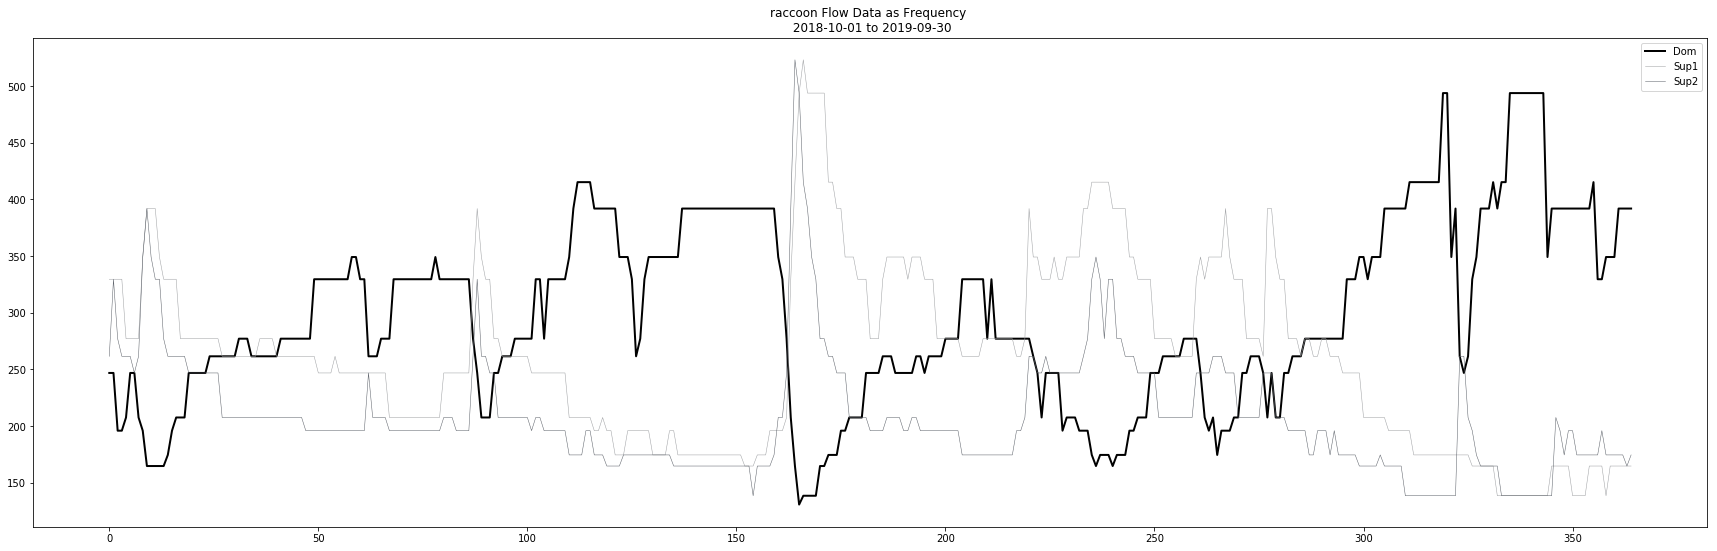

In [18]:
plt.figure(figsize=(30,9))
plt.plot(fd,color='k',linewidth=2)
plt.plot(fs1,color='#9ea0a3',linewidth=0.5)
plt.plot(fs2,color='#5b6068',linewidth=0.5)
plt.legend(['Dom','Sup1','Sup2'])
plt.title('{0} Flow Data as Frequency \n {1} to {2}'.format(subbasin,start,stop))
plt.show()

# PLAY YOUR MASTERPIECE
Moment of truth... what's sound like?

In [13]:
# Wait for playback to finish before exiting
play_obj = sa.play_buffer(full, 1, 2, fs)
play_obj.wait_done()

## If you like it, save it as a wav file

In [57]:
fileName = "music/wav/{0}-{1}-{2}-{3}.wav".format(subbasin,style,start,stop)
wavio.write(fileName, full, fs, sampwidth=2)